In [29]:
import numpy as np
import pyvista as pv
from tqdm import tqdm
import matplotlib.pyplot as plt

In [30]:
def umeyama_rigid(X, Y):
    
    # Get dimension and number of points
    m, n = X.shape
    
    # Demean the point sets X and Y
    X_mean = X.mean(1)
    Y_mean = Y.mean(1)

    X_demean =  X - np.tile(X_mean, (n, 1)).T
    Y_demean =  Y - np.tile(Y_mean, (n, 1)).T
    
    # Computing matrix XY' using demeaned point sets
    XY = np.dot(X_demean, Y_demean.T)

    # Singular value decomposition
    U,D,V = np.linalg.svd(XY,full_matrices=True,compute_uv=True)
    V=V.T.copy()
    
    # Determine rotation
    R = np.dot( V, U.T)

    # Determine translation
    t = Y_mean - np.dot(R, X_mean)
    
    return R,t

In [31]:
def umeyama_similarity(X, Y):
    
    # Get dimension and number of points
    m, n = X.shape

    # Demean the point sets X and Y
    X_mean = X.mean(1) #MODEL ANSWER
    Y_mean = Y.mean(1) #MODEL ANSWER
    
    X_demean =  X - np.tile(X_mean, (n, 1)).T #MODEL ANSWER
    Y_demean =  Y - np.tile(Y_mean, (n, 1)).T #MODEL ANSWER

    # Computing matrix XY' using demeaned and NORMALISED point sets (divide by the number of points n)
    # See Equation (38) in the paper
    XY = np.dot(X_demean, Y_demean.T) / n  #MODEL ANSWER

    # Determine variances of points X and Y, see Equation (36),(37) in the paper
    X_var = np.mean(np.sum(X_demean*X_demean, 0))
    Y_var = np.mean(np.sum(Y_demean*Y_demean, 0))

    # Singular value decomposition
    U,D,V = np.linalg.svd(XY,full_matrices=True,compute_uv=True)
    V=V.T.copy()
    
    # Determine rotation
    R = np.dot( V, U.T) #MODEL ANSWER
    
    # Determine the scaling, see Equation (42) in the paper (assume S to be the identity matrix, so ignore)
    c = np.trace(np.diag(D)) / X_var #MODEL ANSWER

    # Determine translation, see Equation (41) in the paper
    t = Y_mean - c * np.dot(R, X_mean) #MODEL ANSWER

    return R,t,c

In [32]:
from mpl_toolkits.mplot3d import Axes3D

def plot_pts(x,y,z,max_range=None,marker_size=10,figure_size=5):

    fig = plt.figure(figsize=(figure_size, figure_size), dpi=100)
    ax = Axes3D(fig, auto_add_to_figure=False)
    fig.add_axes(ax)
    for idx in range(x.shape[1]):
        ax.scatter(x[:,idx], y[:,idx], z[:,idx], marker='.')

    if max_range == None:
        max_range = np.array([x.max()-x.min(), y.max()-y.min(), z.max()-z.min()]).max() / 2.0

    mid_x = (x.max()+x.min()) * 0.5
    mid_y = (y.max()+y.min()) * 0.5
    mid_z = (z.max()+z.min()) * 0.5
    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(mid_z - max_range, mid_z + max_range)
    ax.view_init(10,45)
    ax.grid()

## Select brain structure and registration mode

In [33]:
brain_structure = 'BrStem'

use_rigid = True

use_subj_dir = False
data_dir = 'data/brain/ixi/meshes'
out_dir = 'data/brain/ixi/meshes-rigid'

## Load meshes

In [34]:
from pathlib import Path

files = Path(data_dir).rglob('*' + brain_structure + '*.vtk')

pts = []
for idx, path in tqdm(enumerate(files), desc='Loading meshes...'):
    mesh = pv.read(str(path))
    vertices = np.hstack( (mesh.points[:,0], mesh.points[:,1], mesh.points[:,2]) )
    pts.append(vertices)
pts = np.array(pts).transpose()

Loading meshes...: 581it [00:03, 179.81it/s]


In [35]:
m, n = pts.shape

num_centroids = m//3;
x_ind = range(num_centroids)
y_ind = range(num_centroids,num_centroids*2)
z_ind = range(num_centroids*2,num_centroids*3)

cx = pts[x_ind,:];
cy = pts[y_ind,:];
cz = pts[z_ind,:];

print('Dimension:\t' + str(m))
print('Samples:\t' + str(n))

Dimension:	1926
Samples:	581


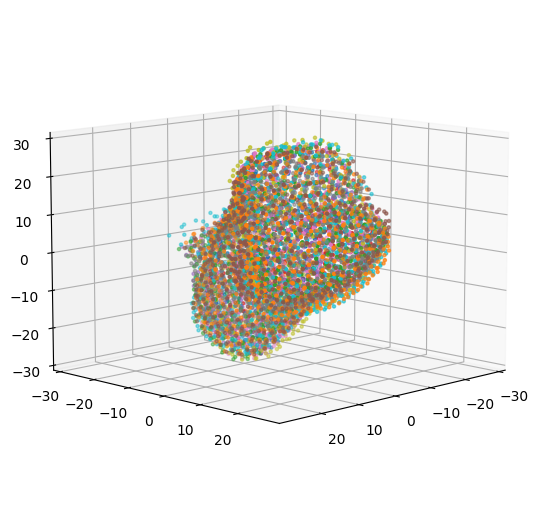

In [36]:
# spatial normalisation
cx_norm = cx - np.tile(np.mean(cx,axis=0),(num_centroids,1))
cy_norm = cy - np.tile(np.mean(cy,axis=0),(num_centroids,1))
cz_norm = cz - np.tile(np.mean(cz,axis=0),(num_centroids,1))

plot_pts(cx_norm[:,0:10], cy_norm[:,0:10], cz_norm[:,0:10], marker_size=10)

## Example of pairwise registration

In [37]:
id_source = 0
id_target = 1

source = np.vstack( (cx[:,id_source], cy[:,id_source], cz[:,id_source]) )
target = np.vstack( (cx[:,id_target], cy[:,id_target], cz[:,id_target]) )

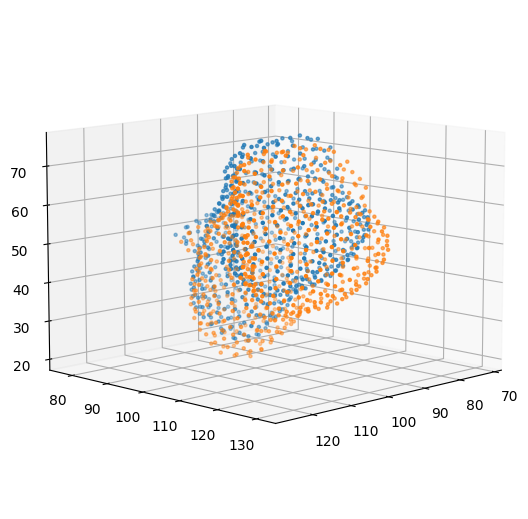

In [38]:
shapes_x = np.vstack((source[0,:], target[0,:])).transpose()
shapes_y = np.vstack((source[1,:], target[1,:])).transpose()
shapes_z = np.vstack((source[2,:], target[2,:])).transpose()
plot_pts( shapes_x, shapes_y, shapes_z, marker_size=10 )

### Rigid registration

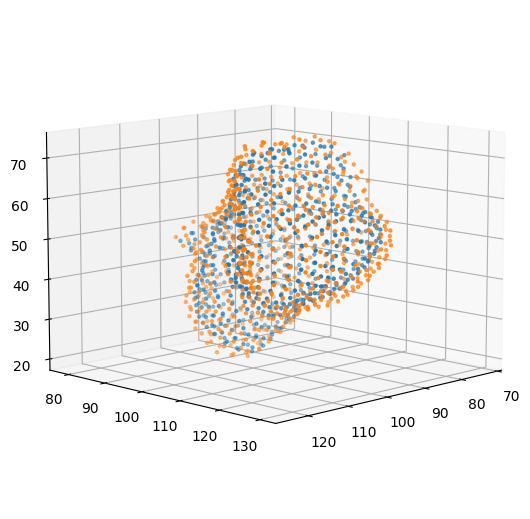

In [39]:
R, t = umeyama_rigid(source, target)
warped = np.dot(R,source) + np.tile(t, (num_centroids, 1)).transpose()

shapes_x = np.vstack((warped[0,:], target[0,:])).transpose()
shapes_y = np.vstack((warped[1,:], target[1,:])).transpose()
shapes_z = np.vstack((warped[2,:], target[2,:])).transpose()
plot_pts( shapes_x, shapes_y, shapes_z, marker_size=10 )

### Similarity registration

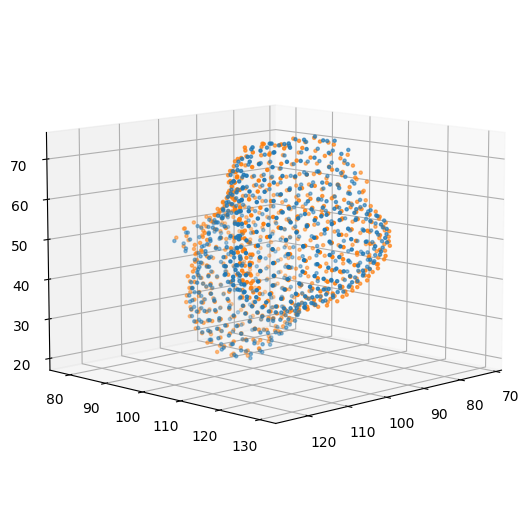

In [40]:
R, t, c = umeyama_similarity(source, target)
warped = c * np.dot(R,source) + np.tile(t, (num_centroids, 1)).transpose()

shapes_x = np.vstack((warped[0,:], target[0,:])).transpose()
shapes_y = np.vstack((warped[1,:], target[1,:])).transpose()
shapes_z = np.vstack((warped[2,:], target[2,:])).transpose()
plot_pts( shapes_x, shapes_y, shapes_z, marker_size=10 )

## Run registration on whole dataset

Registering shapes...: 100%|██████████| 580/580 [00:00<00:00, 4635.40it/s]


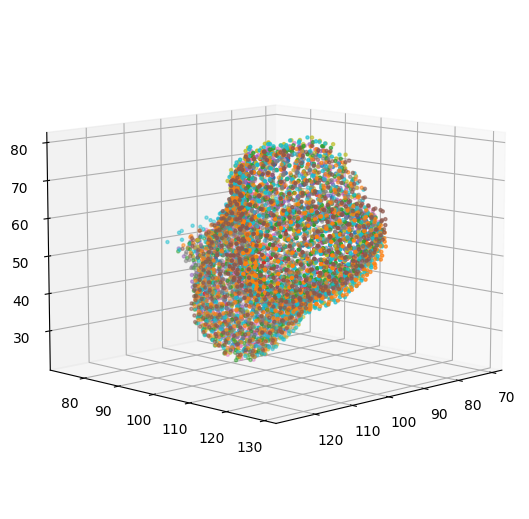

In [41]:
# Switch here between the two methods.
id_target = 0

target = np.vstack( (cx[:,id_target], cy[:,id_target], cz[:,id_target]) )

cx_norm[:,id_target] = target[0,:]
cy_norm[:,id_target] = target[1,:]
cz_norm[:,id_target] = target[2,:]

for i in tqdm(range(1,n), desc='Registering shapes...'):
    source = np.vstack( (cx[:,i], cy[:,i], cz[:,i]) )
    
    if use_rigid:
        R, t = umeyama_rigid(source, target)        
        warped = np.dot(R,source) + np.tile(t, (num_centroids, 1)).transpose()
    else:
        R, t, c = umeyama_similarity(source, target)
        warped = c * np.dot(R,source) + np.tile(t, (num_centroids, 1)).transpose()
    
    cx_norm[:,i] = warped[0,:]
    cy_norm[:,i] = warped[1,:]
    cz_norm[:,i] = warped[2,:]
    
plot_pts(cx_norm[:,0:10], cy_norm[:,0:10], cz_norm[:,0:10], marker_size=10)

## Save registered meshes

In [42]:
import os, glob

pathname = data_dir + '/**/*' + brain_structure + '*.vtk'
files = glob.glob(pathname, recursive=True)

if not os.path.exists(out_dir):
    os.makedirs(out_dir)

for idx, p in tqdm(enumerate(files), desc='Writing meshes...'):    
    p = p.replace(os.sep, '/')
    mesh = pv.read(str(p))
    
    mesh.points[:,0] = cx_norm[:,idx]
    mesh.points[:,1] = cy_norm[:,idx]
    mesh.points[:,2] = cz_norm[:,idx]

    if use_subj_dir:        
        subj_id = os.path.dirname(p).split('/')[-1]
        subj_dir = os.path.join(out_dir,subj_id)
        if not os.path.exists(subj_dir):        
            os.makedirs(subj_dir)
        mesh.save(os.path.join(subj_dir,os.path.basename(p)), binary=False)
    else:
        mesh.save(os.path.join(out_dir,os.path.basename(p)), binary=False)

Writing meshes...: 581it [00:05, 99.81it/s] 
